# Variogram analysis and kriging for data in 2D (omni-directional)

Interpolate a data set in 2D, using simple or ordinary kriging. Starting from a data set in 2D, the following is done:
- basic exploratory analysis: variogram cloud / variogram rose / experimental variogram
- fitting a covariance / variogram model, and cross-validation (LOO error)
- interpolation by ordinary kriging, simple kriging (and simulation)

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# import package 'geone'
import geone as gn

## Preparation - build a data set in 2D

A data set in 2D is extracted from a Gaussian random field generated based on a known covariance model, called the *reference model* which will be considered as unknown further.

Define a (isotropic) *reference* covariance model in 2D (class `geone.covModel.CovModel2D`, see jupyter notebook `ex_grf_2d`).

In [2]:
cov_model_ref = gn.covModel.CovModel2D(elem=[
    ('spherical', {'w':9.5, 'r':[50, 50]}), # elementary contribution (same ranges: isotropic)
    ('nugget', {'w':0.5})                     # elementary contribution
    ], alpha=0.0, name='ref model (isotropic)')

In [3]:
cov_model_ref

Covariance model 2D: (Name = ref model (isotropic))
   2 elementary contribution(s)
   Elementary contribution 0: type : spherical
      parameters:  w = 9.5,  r = [50, 50]
   Elementary contribution 1: type : nugget
      parameters:  w = 0.5
   Angle: alpha = 0.0 deg.
   i.e.: the system Ox'y', supporting the axes of the model (ranges),
         is obtained from the system Oxy by applying a rotation of
         angle -alpha.

Generate a gaussian random field in 2D (see function `geone.grf.grf2D`), and extract data points:
- `n`: number of data points, 
- `x`: location of data points (2-dimensional array of shape `(n, 2)`, each row is a point),
- `v`: values at data points (1-dimensional array of length `n`).

In [4]:
# Simulation grid (domain)
nx, ny = 400, 420  # number of cells
dx, dy = 0.5, 0.5  # cell unit
ox, oy = 0.0, 0.0  # origin

# Reference simulation
np.random.seed(123)
ref = gn.grf.grf2D(cov_model_ref, (nx, ny), (dx, dy), (ox, oy), nreal=1, printInfo=False) 
    # 3d-array of shape 1 x ny x nx

# Extract n points from the reference simulation
n = 50 # number of data points
ind = np.random.choice(nx*ny, size=n, replace=False) # indexes of extracted grid cells
ix = ind%nx  # indexes along x-axis
iy = ind//nx # indexes along y-axis
xc = ox + (ix + 0.5)*dx # x-coordinates of data points (centers of the extracted grid cells)
yc = oy + (iy + 0.5)*dy # y-coordinates of data points (centers of the extracted grid cells)
#xc = ox + (ind + np.random.random(n))*dx # x-coordinates of data points (within the extracted grid cells)
#yc = oy + (ind + np.random.random(n))*dy # y-coordinates of data points (within the extracted grid cells)

x = np.array((xc, yc)).T # array of coordinates of data points (shape: n x 2)
v = ref[0].reshape(-1)[ind] # value at data points

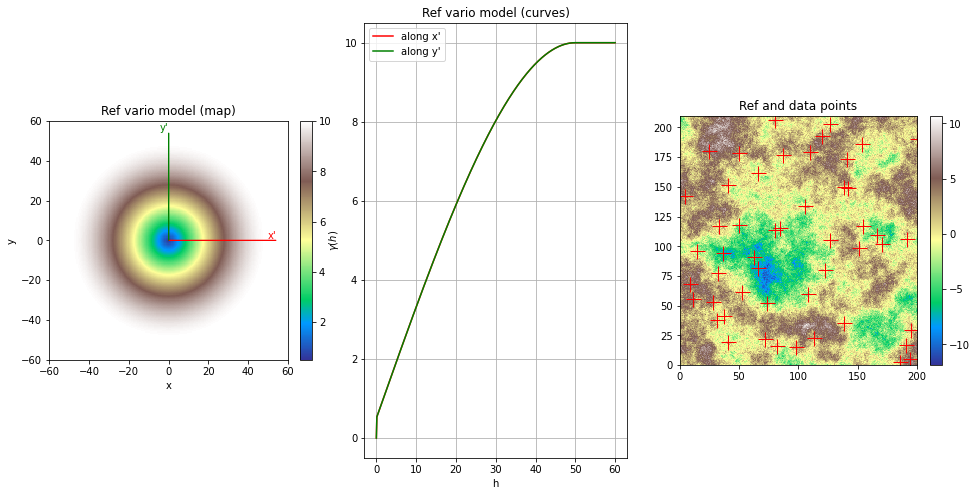

In [5]:
# Plot reference variogram model, reference simulation and data points
plt.subplots(1,3,figsize=(16,8))
plt.subplot(1,3,1)
cov_model_ref.plot_model(vario=True, plot_map=True, plot_curves=False)
plt.title('Ref vario model (map)')
plt.subplot(1,3,2)
cov_model_ref.plot_model(vario=True, plot_map=False, plot_curves=True)
plt.title('Ref vario model (curves)')
plt.subplot(1,3,3)
im_ref = gn.img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=1, val=ref) # fill image (Img class from geone.img) 
                                                                      # for view
gn.imgplot.drawImage2D(im_ref, cmap='terrain')
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)
plt.title('Ref and data points')
plt.show()

## Start from a data set in 2D
- `n`: number of data points, 
- `x`: location of data points (2-dimensional array of shape `(n, 2)`, each row is a point),
- `v`: values at data points (1-dimensional array of length `n`).

Visualise the data set and the histogram of values.

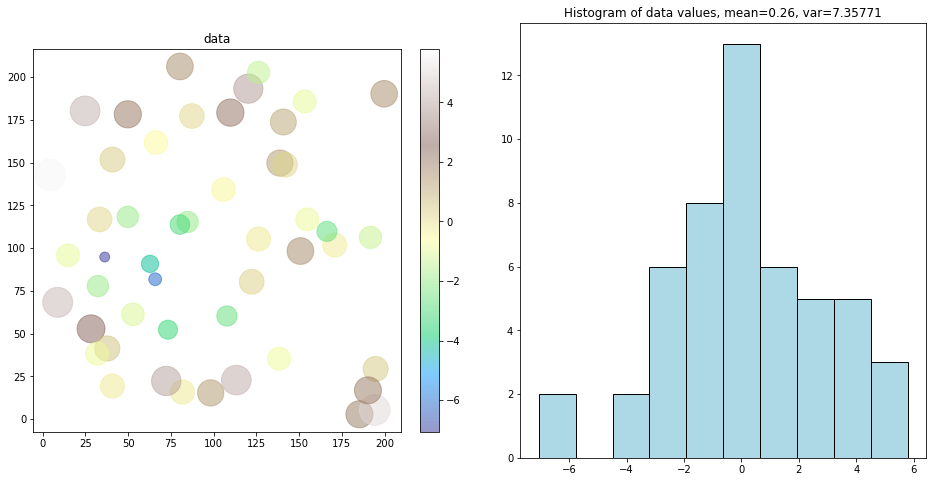

In [6]:
plt.subplots(1,2,figsize=(16,8))
plt.subplot(1,2,1)
vmin, vmax = np.min(v), np.max(v) # min and max of data values
smin, smax = 100, 1000            # min and max size of points on plot
plot = plt.scatter(x[:,0], x[:,1], c=v, s=smin+(v-vmin)/(vmax-vmin)*(smax-smin), alpha=0.5, cmap='terrain')
gn.customcolors.add_colorbar(plot)
plt.axis('equal')
plt.title('data')

plt.subplot(1,2,2)
plt.hist(v, color='lightblue', edgecolor='black')
plt.title('Histogram of data values, mean={:.2g}, var={:2g}'.format(np.mean(v), np.var(v)))
plt.show()

### Variogram rose

The function `geone.covModel.variogramExp2D_rose` shows an experimental variogram for a data set in 2D in the form of a rose plot, *i.e.* the lags vectors between the pairs of data points are divided in classes according to length (radius) and angle from the x-axis counter-clockwise (*warning:* opposite sense to the sense given by angle in definition of a covariance model in 2D).

The keyword argument `r_max` allows to specify a maximal length of 2D-lag vector between a pair of data points for being integrated in the variogram rose plot. The number of classes for radius (length) can be specified by the keyword argument `r_ncla`, and the number of classes for angle for half of the whole disk (rose plot is symmetric with respect to the origin) can be specified by the keyword argument `phi_ncla`.

This function can be useful to check a possible anisotropy.

/home/julien/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/julien/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


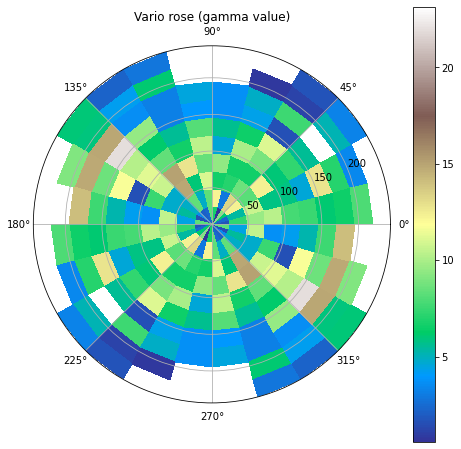

In [7]:
gn.covModel.variogramExp2D_rose(x, v, figsize=(8,8))
plt.show()

For plotting a variogram rose in a multiple axes figure, proceed as follows.

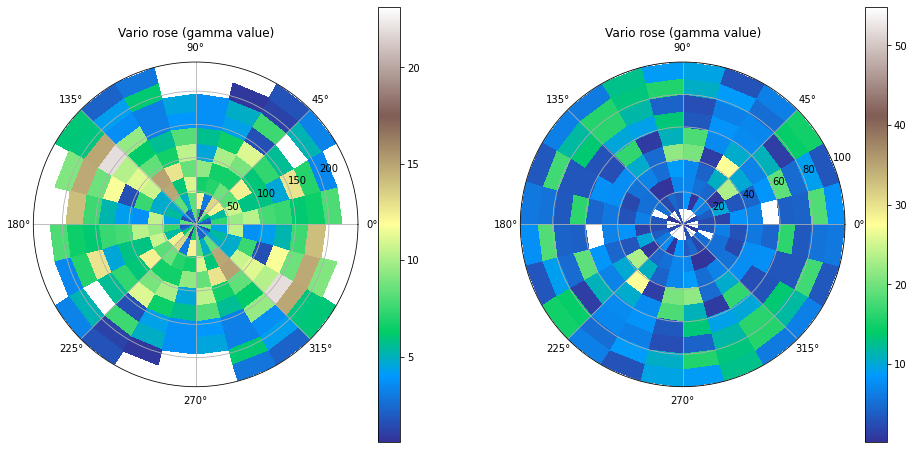

In [8]:
fig = plt.figure(figsize=(16,8))

fig.add_subplot(1,2,1, projection='polar')
gn.covModel.variogramExp2D_rose(x, v, set_polar_subplot=False)

ax = fig.add_subplot(1,2,2, projection='polar')
gn.covModel.variogramExp2D_rose(x, v, r_max=100, set_polar_subplot=False)

plt.show()

As no anisotropy is visible, an omni-directional covariance / variogram model could be used.

### Omni-directional variogram cloud
The function `geone.covModel.variogramCloud1D` is used (see jupyter notebook `ex_vario_analysis_data1D`).

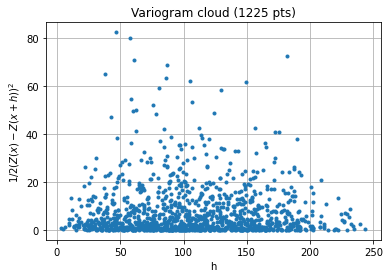

In [9]:
h, g, npair = gn.covModel.variogramCloud1D(x, v)
plt.show()

### Omni-directional experimental variogram
The function `geone.covModel.variogramExp1D` is used (see jupyter notebook `ex_vario_analysis_data1D`).

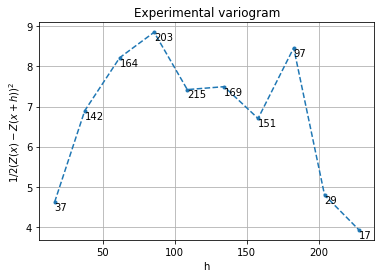

In [10]:
hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v)
# hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v, variogramCloud=(g, h, npair)) # equivalent (x, v not used) 
plt.show()

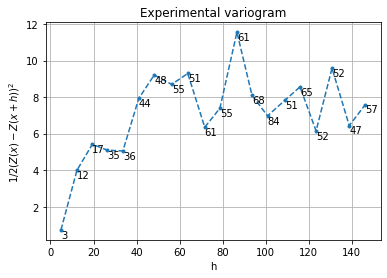

In [11]:
hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v, hmax=150, ncla=20)
plt.show()

### Omni-directional model fitting
The function `geone.covModel.covModel1D_fit` is used to fit a covariance model in 1D (class `geone.covModel.CovModel1D`) (see jupyter notebook `ex_vario_analysis_data1D`).

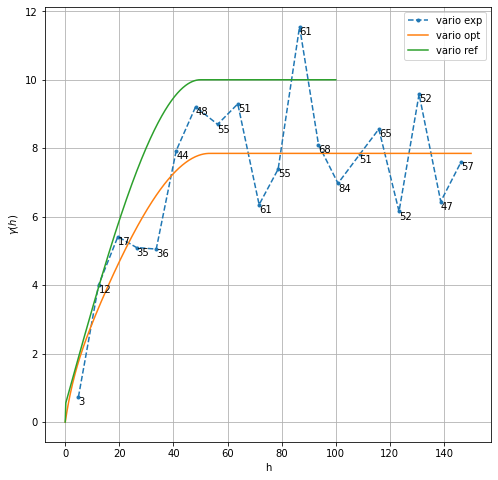

Covariance model 1D: (Name = )
   4 elementary contribution(s)
   Elementary contribution 0: type : gaussian
      parameters:  w = 4.702326458131358e-05,  r = 50.00291958255431
   Elementary contribution 1: type : spherical
      parameters:  w = 6.804383810898631,  r = 53.39866319281066
   Elementary contribution 2: type : exponential
      parameters:  w = 1.044494438717484,  r = 9.383548121295695
   Elementary contribution 3: type : nugget
      parameters:  w = 7.805263369251372e-05

In [12]:
cov_model_to_optimize = gn.covModel.CovModel1D(
    elem=[('gaussian',    {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('spherical',   {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('exponential', {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('nugget',      {'w':np.nan})              # elementary contribution
         ], name='')

cov_model_opt, popt = gn.covModel.covModel1D_fit(x, v, cov_model_to_optimize, hmax=200,
                        bounds=([ 0,   0,  0,   0,  0,   0,  0],  # min value for param. to fit
                                [20, 100, 20, 100, 20, 100, 20]), # max value for param. to fit
                        make_plot=False)
plt.figure(figsize=(8,8))
gn.covModel.plot_variogramExp1D(hexp, gexp, cexp, label='vario exp')
cov_model_opt.plot_model(vario=True, hmax=150, label='vario opt') # cov. model in 1D
cov_model_ref.plot_model_one_curve(vario=True, hmax=100, label='vario ref') # cov. model in 2D
plt.legend()
plt.show()
cov_model_opt

### Cross-validation of covariance model by leave-one-out error
The function `geone.covModel.cross_valid_loo` makes a cross-validation test by leave-one-out (LOO) error. 

For a given a data set (in 2D) and a covariance model in 1D, this latter defines an omni-directional covariance model.

See jupyter notebook `ex_vario_analysis_data1D` for more details about this function.

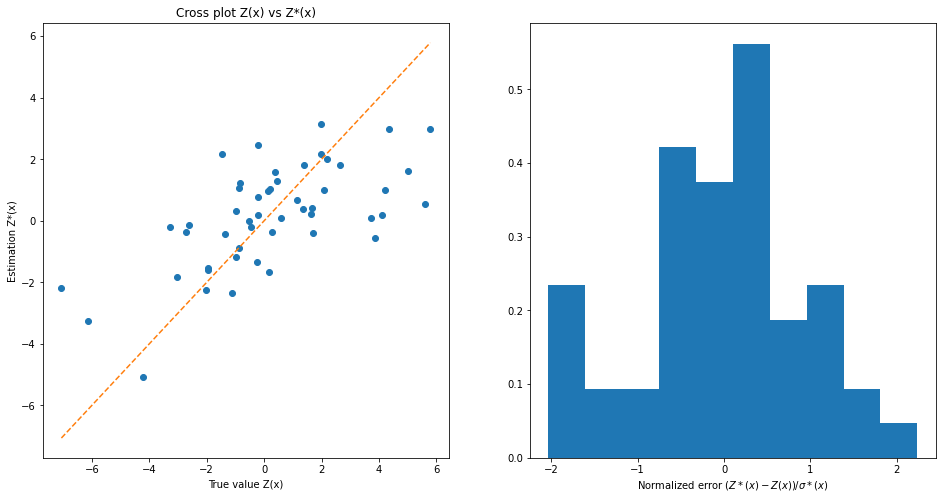

Test (1. normal law test for mean of normalized error) passed: True
Test (2. Chi2 test for sum of squares of normalized error) passed: True


In [13]:
# Interpolation by simple kriging
cv_est1, cv_std1, test_normal, test_chi2 = gn.covModel.cross_valid_loo(x, v, cov_model_opt,
                                                                       #interpolator_kwargs={'mean':np.mean(v)},
                                                                       make_plot=True, figsize=(16,8))
plt.show()
print('\
Test (1. normal law test for mean of normalized error) passed: {}\n\
Test (2. Chi2 test for sum of squares of normalized error) passed: {}'.format(test_normal, test_chi2))

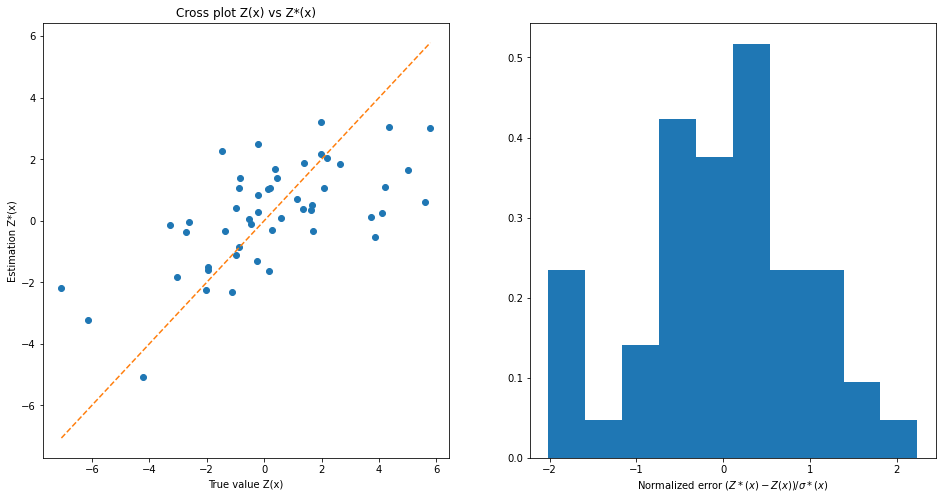

Test (1. normal law test for mean of normalized error) passed: True
Test (2. Chi2 test for sum of squares of normalized error) passed: True


In [14]:
# Interpolation by ordinary kriging
cv_est2, cv_std2, test_normal, test_chi2 = gn.covModel.cross_valid_loo(x, v, cov_model_opt,
                                                interpolator_kwargs={'method':'ordinary_kriging'},
                                                make_plot=True, figsize=(16,8))
plt.show()
print('\
Test (1. normal law test for mean of normalized error) passed: {}\n\
Test (2. Chi2 test for sum of squares of normalized error) passed: {}'.format(test_normal, test_chi2))

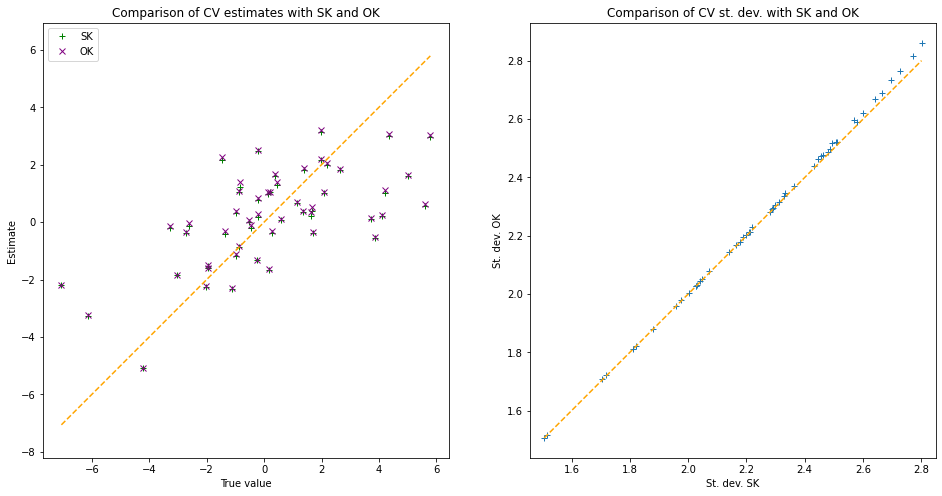

In [15]:
# Comparison of cross-validation with simple and kriging and ordinary kriging
plt.subplots(1, 2, figsize=(16,8))

plt.subplot(1,2,1)
# plt.plot(cv_est1, cv_est2, marker='+', ls='')
# plt.plot([np.min(cv_est1), np.max(cv_est1)], [np.min(cv_est1), np.max(cv_est1)], c='orange', ls='dashed')
# plt.axis('equal')
# plt.xlabel('Estimate SK')
# plt.ylabel('Estimate OK')
plt.plot(v, cv_est1, c='green', marker='+', ls='', label='SK')
plt.plot(v, cv_est2, c='purple', marker='x', ls='', label='OK')
plt.plot([np.min(v), np.max(v)], [np.min(v), np.max(v)], c='orange', ls='dashed')
plt.axis('equal')
plt.xlabel('True value')
plt.ylabel('Estimate')
plt.legend()
plt.title('Comparison of CV estimates with SK and OK')

plt.subplot(1,2,2)
plt.plot(cv_std1, cv_std2, marker='+', ls='')
plt.plot([np.min(cv_std1), np.max(cv_std1)], [np.min(cv_std1), np.max(cv_std1)], c='orange', ls='dashed')
plt.axis('equal')
plt.xlabel('St. dev. SK')
plt.ylabel('St. dev. OK')
plt.title('Comparison of CV st. dev. with SK and OK')
plt.show()

If one test failed (or if the covariance model does not display the desired shape), the covariance model should be rejected and the search for a convenient covariance model be pursued. 

### Data interpolation by (simple or ordinary) kriging: function `geone.covModel.krige`
The function `geone.covModel.krige(x, v, xu, cov_model, method='simple_kriging', mean=None)` return the kriging estimates and standard deviation at location `xu`, given the data points located at `x` with value `v` and the covariance model `cov_model`. Type of kriging is determined by the keyword argument `method`:
- `method='simple_kriging'` (default): simple kriging is used, with the mean automatically set to the mean of the data values (`mean=None`); a specified mean value or array (for non-stationary mean) can be set manually with the keyword argument `mean`.
- `method='ordinary_kriging'`: ordinary kriging is used (the keyword argument `mean` is ignored (not used))

For a given a data set (in 2D) and a covariance model in 1D, this latter defines an omni-directional covariance model.

For data in 2D:
- `x`: 2-dimensional array of shape `(n, 2)`, location of data points (each row is a point),
- `v`: 1-dimensional array of length `n`, values at data points,
- `xu`: 2-dimensional array of shape `(m, 2)` location of points where the interpolation is done. 

In return:
- `vu`: 1-dimensional array of length `m`, kriging estimates at location `xu`,
- `vu_std`: 1-dimensional array of length `m`, kriging standard deviation at location `xu`.

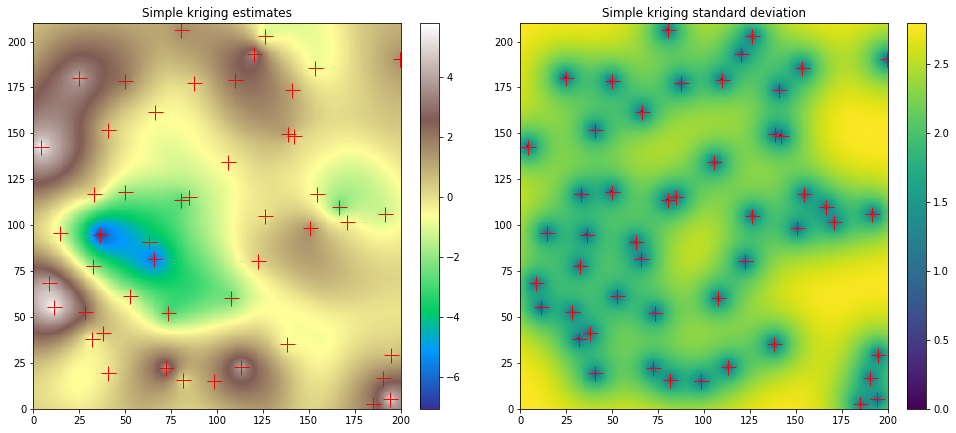

In [16]:
# Define points xu where to interpolate
# ... location of the 2D-grid used to build the data set (but it could be different)
xcu = ox + (np.arange(nx)+0.5)*dx # x-coordinates of points
ycu = oy + (np.arange(ny)+0.5)*dy # y-coordinates of points
xxcu, yycu = np.meshgrid(xcu, ycu)
xu = np.array((xxcu.reshape(-1), yycu.reshape(-1))).T # 2-dimensional array of shape nx*ny x 2

# Simple kriging
vu, vu_std = gn.covModel.krige(x, v, xu, cov_model_opt, method='simple_kriging')
# vu:     1-dimensional array, kriging estimates at location xu
# vu_std: 1-dimensional array, kriging standard deviation at location xu

# Fill image (Img class from geone.img) for view
#   variable 0: kriging estimates
#   variable 1: kriging standard deviation
im_krig = gn.img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=2, val=np.array((vu, vu_std)))

# Plot
plt.subplots(1,2, figsize=(16,8))

plt.subplot(1,2,1)
gn.imgplot.drawImage2D(im_krig, iv=0, cmap='terrain', title='Simple kriging estimates')
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.subplot(1,2,2)
gn.imgplot.drawImage2D(im_krig, iv=1, cmap='viridis', title='Simple kriging standard deviation')
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.show()

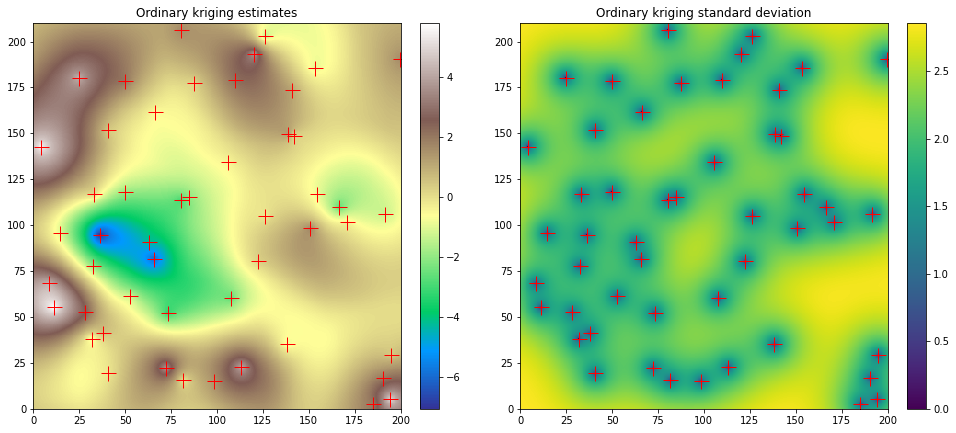

In [17]:
# Define points xu where to interpolate
# ... location of the 2D-grid used to build the data set (but it could be different)
xcu = ox + (np.arange(nx)+0.5)*dx # x-coordinates of points
ycu = oy + (np.arange(ny)+0.5)*dy # y-coordinates of points
xxcu, yycu = np.meshgrid(xcu, ycu)
xu = np.array((xxcu.reshape(-1), yycu.reshape(-1))).T # 2-dimensional array of shape nx*ny x 2

# Ordinary kriging
vu, vu_std = gn.covModel.krige(x, v, xu, cov_model_opt, method='ordinary_kriging')
# vu:     1-dimensional array, kriging estimates at location xu
# vu_std: 1-dimensional array, kriging standard deviation at location xu

# Fill image (Img class from geone.img) for view
#   variable 0: kriging estimates
#   variable 1: kriging standard deviation
im_krig = gn.img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=2, val=np.array((vu, vu_std)))

# Plot
plt.subplots(1,2, figsize=(16,8))

plt.subplot(1,2,1)
gn.imgplot.drawImage2D(im_krig, iv=0, cmap='terrain', title='Ordinary kriging estimates')
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.subplot(1,2,2)
gn.imgplot.drawImage2D(im_krig, iv=1, cmap='viridis', title='Ordinary kriging standard deviation')
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.show()

## Alternatives for kriging estimation and simulation
The module `geone.geosclassicinterface` allows to perform kriging interpolation (estimation) and simulation (sequential Gaussian simulation, SGS) (see jupyter notebook `ex_geosclassic_2d` for 2D case):
- function `geone.geosclassicinterface.estimate2D`: estimation in a 2D grid, *i.e* kriging estimates and standard deviation, for simple or ordinary kriging
- function `geone.geosclassicinterface.simulate2D`: simulation in a 2D grid, based on simple or ordinary kriging; allows also to handle inequality data

The module `geone.grf` allows to perform kriging interpolation (estimation) and simulation (sequential Gaussian simulation, SGS) (see jupyter notebook `ex_geosclassic_2d` for 2D case):
- function `geone.grf.krige2D`: estimation a 2D grid, *i.e* kriging estimates and standard deviation, for simple kriging only
- function `geone.grf.grf2D`: simulation a 2D grid, based on simple kriging only

Note that for these functions, the conditioning values will be attached to the grid cells containing the corresponding conditioning locations.

As these functions require a covariance model in 2D (class `geone.covModel.CovModel2D`), the omni-directional covariance model considered (model in 1D) must be converted first.

In [18]:
cov_model_opt2D = gn.covModel.covModel1D_to_covModel2D(cov_model_opt) # convert model 1D in 2D

### Examples

### Estimation using the function `geone.covModel.krige`

In [19]:
t1 = time.time()
vu, vu_std = gn.covModel.krige(x, v, xu, cov_model_opt, method='simple_kriging')
t2 = time.time()
print('Elapsed time in seconds: {}'.format(t2-t1))

Elapsed time in seconds: 0.8711361885070801


### Estimation using the function `geone.grf.krige2D`

In [20]:
t1 = time.time()
vu_grf, vu_std_grf = gn.grf.krige2D(x, v, cov_model_opt2D, (nx, ny), (dx, dy), (ox, oy), printInfo=False)
t2 = time.time()
print('Elapsed time in seconds: {}'.format(t2-t1))

Elapsed time in seconds: 0.7484972476959229


### Estimation using the function `geone.geosclassicinterface.estimate2D`

In [21]:
t1 = time.time()
estim_gci = gn.geosclassicinterface.estimate2D(cov_model_opt2D, (nx, ny), (dx, dy), (ox, oy), x=x, v=v, 
                                               method='simple_kriging', use_unique_neighborhood=True)
t2 = time.time()
print('Elapsed time in seconds: {}'.format(t2-t1))

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20210831 / OpenMP 7 thread(s)]
Geos-Classic run complete
Elapsed time in seconds: 7.761642217636108


### Plot results of estimation

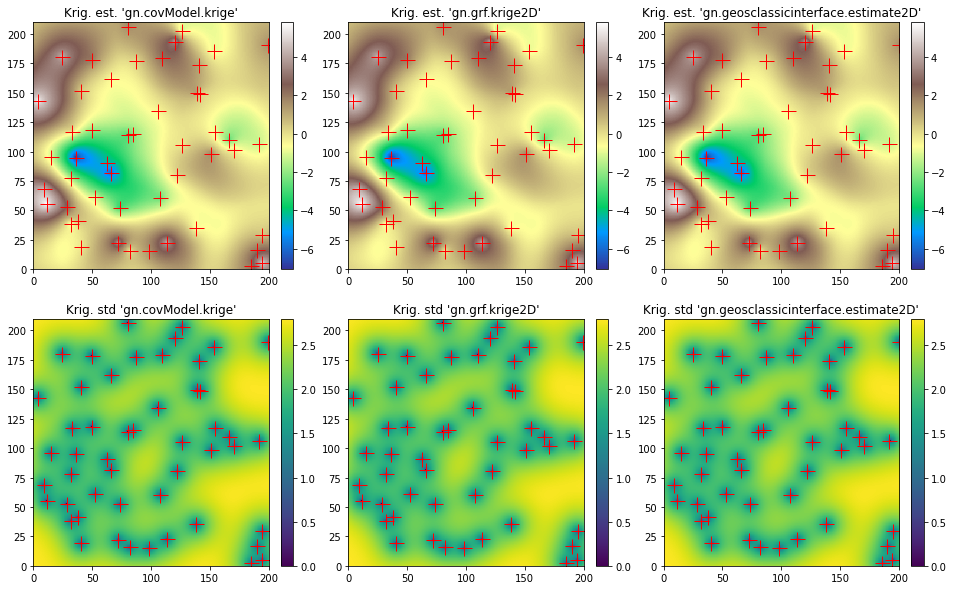

In [22]:
# Fill images (Img class from geone.img) for view
#   variable 0: kriging estimates
#   variable 1: kriging standard deviation
im_krig = gn.img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=2, val=np.array((vu, vu_std)))
im_grf = gn.img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=2, val=np.array((vu_grf, vu_std_grf)))
im_gci = estim_gci['image']

# Plot
plt.subplots(2,3, figsize=(16,10))

plt.subplot(2,3,1)
gn.imgplot.drawImage2D(im_krig, iv=0, cmap='terrain', title="Krig. est. 'gn.covModel.krige'")
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.subplot(2,3,2)
gn.imgplot.drawImage2D(im_grf, iv=0, cmap='terrain', title="Krig. est. 'gn.grf.krige2D'")
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.subplot(2,3,3)
gn.imgplot.drawImage2D(im_gci, iv=0, cmap='terrain', title="Krig. est. 'gn.geosclassicinterface.estimate2D'")
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.subplot(2,3,4)
gn.imgplot.drawImage2D(im_krig, iv=1, cmap='viridis', title="Krig. std 'gn.covModel.krige'")
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.subplot(2,3,5)
gn.imgplot.drawImage2D(im_grf, iv=1, cmap='viridis', title="Krig. std 'gn.grf.krige2D'")
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.subplot(2,3,6)
gn.imgplot.drawImage2D(im_gci, iv=1, cmap='viridis', title="Krig. std 'gn.geosclassicinterface.estimate2D'")
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.show()

In [23]:
print("Peak-to-peak estimation 'gn.covModel.krige - gn.grf.krige2D'                     = {}".format(np.ptp(im_krig.val[0] - im_grf.val[0])))
print("Peak-to-peak estimation 'gn.covModel.krige - gn.geosclassicinterface.estimate2D' = {}".format(np.ptp(im_krig.val[0] - im_gci.val[0])))
print("Peak-to-peak estimation 'gn.grf.krige2D    - gn.geosclassicinterface.estimate2D' = {}".format(np.ptp(im_grf.val[0] - im_gci.val[0])))
print("Peak-to-peak st. dev.   'gn.covModel.krige - gn.grf.krige2D'                     = {}".format(np.ptp(im_krig.val[1] - im_grf.val[1])))
print("Peak-to-peak st. dev.   'gn.covModel.krige - gn.geosclassicinterface.estimate2D' = {}".format(np.ptp(im_krig.val[1] - im_gci.val[1])))
print("Peak-to-peak st. dev.   'gn.grf.krige2D    - gn.geosclassicinterface.estimate2D' = {}".format(np.ptp(im_grf.val[1] - im_gci.val[1])))

Peak-to-peak estimation 'gn.covModel.krige - gn.grf.krige2D'                     = 4.205249042599224e-07
Peak-to-peak estimation 'gn.covModel.krige - gn.geosclassicinterface.estimate2D' = 1.1146639167236572e-13
Peak-to-peak estimation 'gn.grf.krige2D    - gn.geosclassicinterface.estimate2D' = 4.205249112265719e-07
Peak-to-peak st. dev.   'gn.covModel.krige - gn.grf.krige2D'                     = 2.980339841585078e-08
Peak-to-peak st. dev.   'gn.covModel.krige - gn.geosclassicinterface.estimate2D' = 2.980234381499969e-08
Peak-to-peak st. dev.   'gn.grf.krige2D    - gn.geosclassicinterface.estimate2D' = 1.8562928971732617e-12


### Conditional simulation using the function `geone.grf.grf2D`

In [24]:
np.random.seed(293)

t1 = time.time()
nreal = 100
sim_grf = gn.grf.grf2D(cov_model_opt2D, (nx, ny), (dx, dy), (ox, oy), x=x, v=v, nreal=nreal, printInfo=False)
t2 = time.time()
print('Elapsed time in seconds: {}'.format(t2-t1))

Elapsed time in seconds: 7.428391456604004


### Conditional simulation using the function `geone.geosclassicinterface.simulate2D`

In [25]:
np.random.seed(293)

t1 = time.time()
nreal = 100
sim_gci = gn.geosclassicinterface.simulate2D(cov_model_opt2D, (nx, ny), (dx, dy), (ox, oy), x=x, v=v, nreal=nreal, 
                                             method='simple_kriging')
t2 = time.time()
print('Elapsed time in seconds: {}'.format(t2-t1))

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20210831 / OpenMP 7 thread(s)]
Geos-Classic run complete
Elapsed time in seconds: 51.693466663360596


### Plot some realizations and compare to the reference simulation

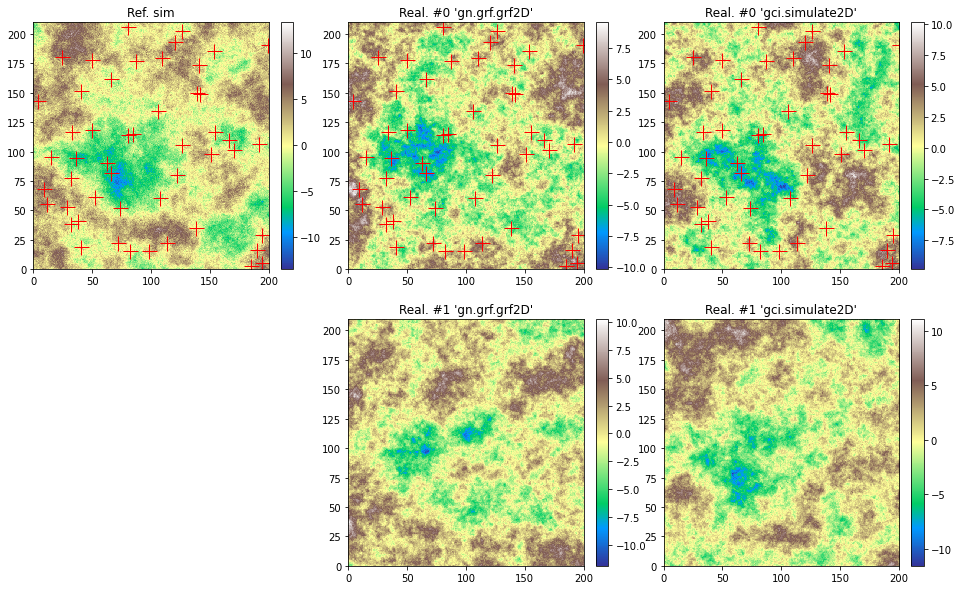

In [26]:
# Fill images (Img class from geone.img) for view
#   variable i: i-th realization
im_sim_grf = gn.img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=nreal, val=sim_grf)
im_sim_gci = sim_gci['image']

# min and max over all real and ref. sim
im_vmin = min(np.min(im_sim_grf.vmin()), np.min(im_sim_gci.vmin()), im_ref.vmin()[0]) 
im_vmax = max(np.max(im_sim_grf.vmax()), np.min(im_sim_gci.vmax()), im_ref.vmax()[0]) 

# Plot
plt.subplots(2,3, figsize=(16,10))

plt.subplot(2,3,1)
gn.imgplot.drawImage2D(im_ref, cmap='terrain', vmin=im_vmin, vmax=im_vmax, title='Ref. sim')
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.subplot(2,3,2)
gn.imgplot.drawImage2D(im_sim_grf, iv=0, cmap='terrain', title="Real. #0 'gn.grf.grf2D'")
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.subplot(2,3,3)
gn.imgplot.drawImage2D(im_sim_gci, iv=0, cmap='terrain', title="Real. #0 'gci.simulate2D'")
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.subplot(2,3,4)
plt.axis('off')

plt.subplot(2,3,5)
gn.imgplot.drawImage2D(im_sim_grf, iv=1, cmap='terrain', title="Real. #1 'gn.grf.grf2D'")
#plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.subplot(2,3,6)
gn.imgplot.drawImage2D(im_sim_gci, iv=1, cmap='terrain', title="Real. #1 'gci.simulate2D'")
#plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.show()

Note that the nugget weight in the optimal covariance model found is near zero, whereas in the reference covariance model, its value is 0.5. As a matter of fact, the reference simulation above is a bit more "noisy". To ensure a larger nugget in the optimal covariance model, a minimal bound can be set accordingly for this parameter and passed to the function `geone.covModel.covModel1D_fit`.